# Comparing Model Performance: Ground Truth vs. Own Retrieved Chunks

This notebook analyzes the performance difference between models when using ground truth chunks versus your own retrieved chunks. We'll compare the metrics and visualize the differences to understand how much performance degrades with custom retrieval.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import re

## Load Data

Let's load both CSV files - one with ground truth chunks and another with your own retrieved chunks.

In [2]:
# Let's assume the files are named: ground_truth.csv and own_retrieval.csv
# Update these filenames to match your actual files
ground_truth_file = "./evaluation_summary_report.csv"
own_retrieval_file = "./evaluation_end_to_end_summary_report.csv"

# Read CSV files
ground_truth_df = pd.read_csv(ground_truth_file)
own_retrieval_df = pd.read_csv(own_retrieval_file)

# Display the first few rows of each dataframe to confirm loading
print("Ground Truth Data:")
display(ground_truth_df.head(2))
print("\nOwn Retrieval Data:")
display(own_retrieval_df.head(2))

Ground Truth Data:


,file_name,bertscore_precision,bertscore_recall,bertscore_f1,ref_cand_sim,query_cand_relevance,aggregated_metric,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1
0,baseline_lorem.csv,0.326193,0.348112,0.336542,-0.028258,-0.007892,0.005231,0.015462,0.012079,0.012980,0.000000,0.000000,0.000000,0.014437,0.011521,0.012270
1,mistral-small3.1.csv,0.610680,0.639673,0.620945,0.600561,0.594231,0.786480,0.324083,0.425538,0.317969,0.114311,0.146536,0.112457,0.223232,0.283931,0.213724



Own Retrieval Data:


,file_name,bertscore_precision,bertscore_recall,bertscore_f1,ref_cand_sim,query_cand_relevance,aggregated_metric,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1
0,test_end_to_end_gemma3:12b.csv,0.618141,0.614516,0.613835,0.577504,0.593764,0.726681,0.358157,0.324325,0.308539,0.112237,0.096848,0.093738,0.245609,0.213917,0.20572
1,test_end_to_end_gemma3:27b.csv,0.618867,0.629603,0.622209,0.591993,0.560496,0.703299,0.334904,0.356241,0.320096,0.095655,0.100076,0.090740,0.221658,0.231410,0.20822


## Preprocess Model Names

Let's extract model names from the file names to make them more readable and comparable.

In [3]:
def extract_model_name(filename):
    # Remove .csv extension
    name = filename.replace(".csv", "")
    # Return cleaned model name
    if name.startswith("test_end_to_end_"):
        name = name.replace("test_end_to_end_", "")
    return name

# Add model name as a new column
ground_truth_df['model'] = ground_truth_df['file_name'].apply(extract_model_name)
own_retrieval_df['model'] = own_retrieval_df['file_name'].apply(extract_model_name)

# Get list of models present in both datasets
common_models = set(ground_truth_df['model']).intersection(set(own_retrieval_df['model']))
print(f"Models present in both datasets: {len(common_models)}")
print(common_models)

Models present in both datasets: 2
{'gemma3:12b', 'gemma3:27b'}


## Filter Data for Common Models

Let's filter our data to include only models that are present in both datasets.

In [4]:
# Filter dataframes to include only common models
ground_truth_filtered = ground_truth_df[ground_truth_df['model'].isin(common_models)]
own_retrieval_filtered = own_retrieval_df[own_retrieval_df['model'].isin(common_models)]

# Sort both dataframes by model name for consistent comparison
ground_truth_filtered = ground_truth_filtered.sort_values('model')
own_retrieval_filtered = own_retrieval_filtered.sort_values('model')

print(f"Number of models after filtering: {len(ground_truth_filtered)}")

Number of models after filtering: 2


## Define Key Metrics for Comparison

Let's define which metrics we want to compare between the two datasets.

In [5]:
# Define key metrics for comparison
metrics = [
    'bertscore_f1',
    'aggregated_metric',
    'rouge1_f1',
    'rouge2_f1',
    'rougeL_f1',
    'ref_cand_sim',
    'query_cand_relevance'
]

# Create a comparison dataframe
comparison_data = []

for model in common_models:
    gt_row = ground_truth_filtered[ground_truth_filtered['model'] == model].iloc[0]
    own_row = own_retrieval_filtered[own_retrieval_filtered['model'] == model].iloc[0]
    
    model_data = {'model': model}
    
    for metric in metrics:
        model_data[f"{metric}_ground_truth"] = gt_row[metric]
        model_data[f"{metric}_own_retrieval"] = own_row[metric]
        model_data[f"{metric}_difference"] = gt_row[metric] - own_row[metric]
        model_data[f"{metric}_percent_change"] = ((gt_row[metric] - own_row[metric]) / gt_row[metric]) * 100 if gt_row[metric] != 0 else 0
    
    comparison_data.append(model_data)

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df[['model'] + [f"{metric}_difference" for metric in metrics]].head())

,model,bertscore_f1_difference,aggregated_metric_difference,rouge1_f1_difference,rouge2_f1_difference,rougeL_f1_difference,ref_cand_sim_difference,query_cand_relevance_difference
0,gemma3:12b,0.006727,0.006035,0.017266,0.013475,0.015721,0.017488,-0.033159
1,gemma3:27b,0.014648,0.015543,0.025777,0.022724,0.015869,0.033781,-0.020382


## Summary Statistics

Let's compute summary statistics for the differences between ground truth and own retrieval.

In [6]:
# Calculate average differences across all models for each metric
avg_differences = {}
for metric in metrics:
    avg_differences[metric] = {
        'mean_difference': comparison_df[f"{metric}_difference"].mean(),
        'mean_percent_change': comparison_df[f"{metric}_percent_change"].mean(),
        'max_difference': comparison_df[f"{metric}_difference"].max(),
        'min_difference': comparison_df[f"{metric}_difference"].min()
    }

# Convert to dataframe for better display
avg_diff_df = pd.DataFrame(avg_differences).transpose()
avg_diff_df['mean_percent_change'] = avg_diff_df['mean_percent_change'].round(2).astype(str) + '%'

display(avg_diff_df)

,mean_difference,mean_percent_change,max_difference,min_difference
bertscore_f1,0.010688,1.69%,0.014648,0.006727
aggregated_metric,0.010789,1.49%,0.015543,0.006035
rouge1_f1,0.021522,6.38%,0.025777,0.017266
rouge2_f1,0.018100,16.3%,0.022724,0.013475
rougeL_f1,0.015795,7.09%,0.015869,0.015721
ref_cand_sim,0.025635,4.17%,0.033781,0.017488
query_cand_relevance,-0.026771,-4.84%,-0.020382,-0.033159


## Rank Models by Performance

Let's rank models by their performance in both scenarios and see if rankings change.

In [7]:
# Create ranking dataframes for each scenario
ranking_data = {}

for metric in metrics:
    # Extract ground truth and own retrieval values
    gt_values = ground_truth_filtered[['model', metric]].copy()
    gt_values.columns = ['model', 'value']
    gt_values['scenario'] = 'ground_truth'
    
    own_values = own_retrieval_filtered[['model', metric]].copy()
    own_values.columns = ['model', 'value']
    own_values['scenario'] = 'own_retrieval'
    
    # Combine values
    combined = pd.concat([gt_values, own_values])
    
    # Create pivot table for side-by-side comparison
    pivot = combined.pivot(index='model', columns='scenario', values='value')
    
    # Add ranks
    pivot['ground_truth_rank'] = pivot['ground_truth'].rank(ascending=False)
    pivot['own_retrieval_rank'] = pivot['own_retrieval'].rank(ascending=False)
    pivot['rank_change'] = pivot['ground_truth_rank'] - pivot['own_retrieval_rank']
    
    ranking_data[metric] = pivot

# Display ranking changes for a key metric (e.g., bertscore_f1)
key_metric = 'bertscore_f1'
ranking_display = ranking_data[key_metric].sort_values('ground_truth', ascending=False)
print(f"Model Rankings based on {key_metric}:")
display(ranking_display)

Model Rankings based on bertscore_f1:


scenario,ground_truth,own_retrieval,ground_truth_rank,own_retrieval_rank,rank_change
model,,,,,
gemma3:27b,0.636858,0.622209,1.0,1.0,0.0
gemma3:12b,0.620562,0.613835,2.0,2.0,0.0


## Visualizations

Let's create visualizations to compare metrics between ground truth and own retrieval.

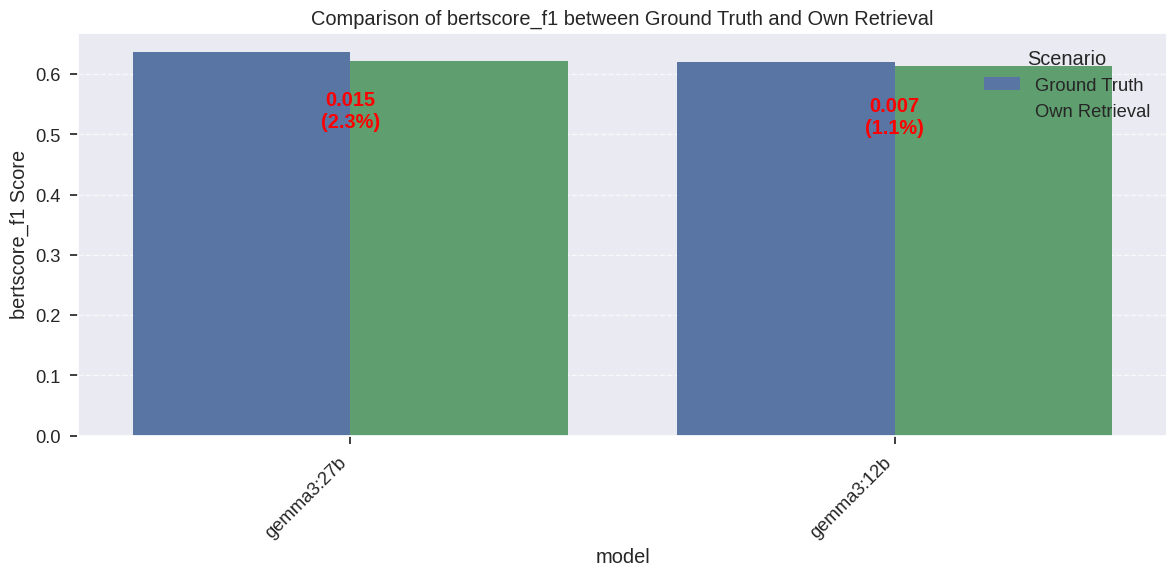

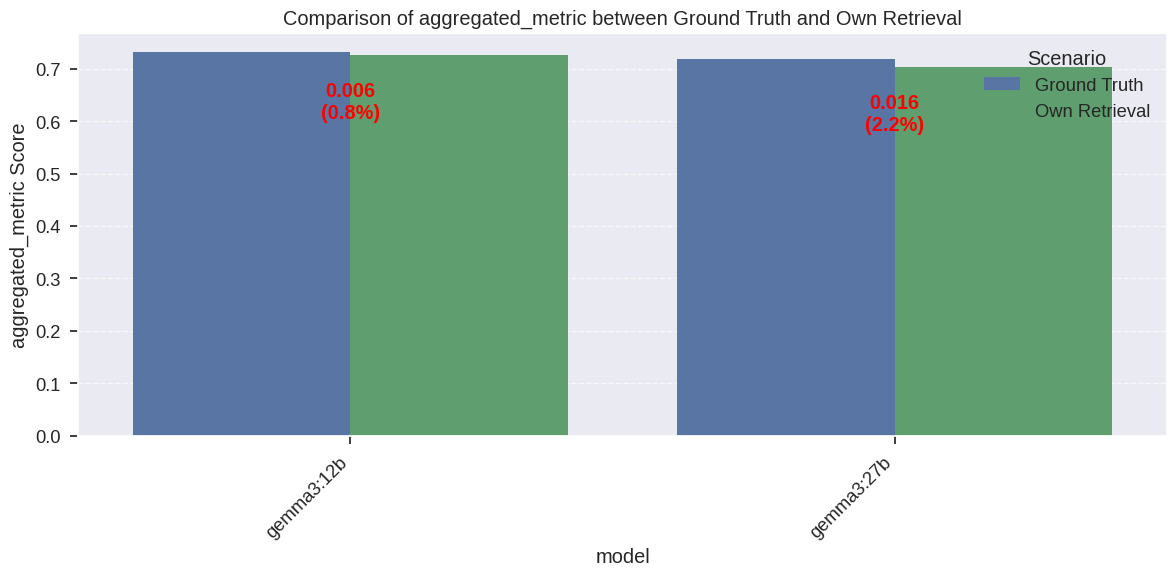

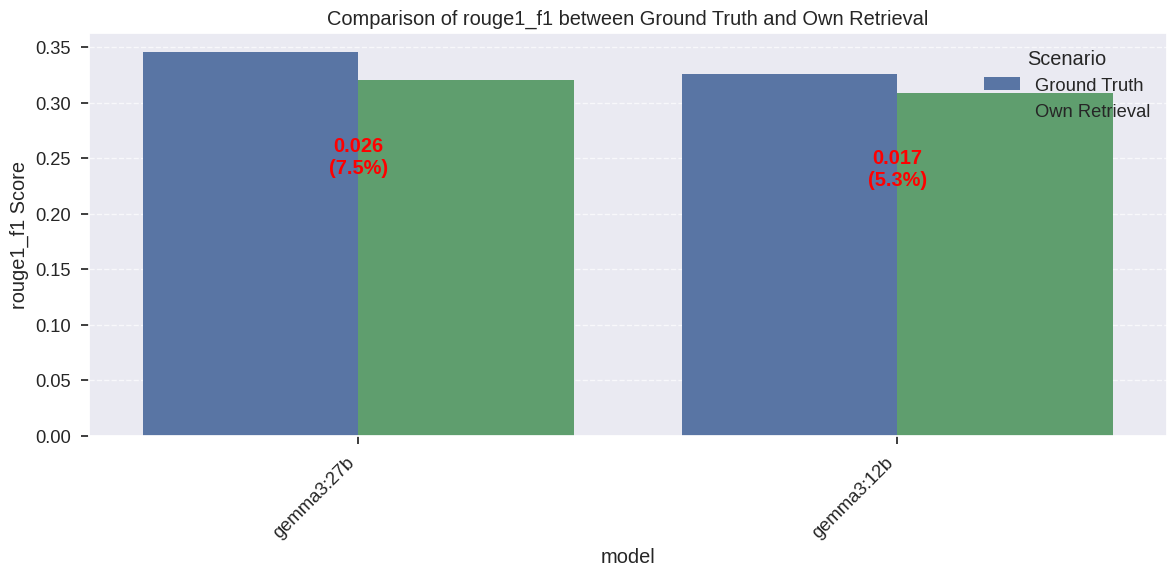

In [8]:
# Set the style for plots
plt.style.use('seaborn-v0_8')
sns.set_context("notebook", font_scale=1.2)

# Create bar charts for key metrics
for metric in metrics[:3]:  # Limiting to first 3 metrics for brevity
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    plot_data = comparison_df[['model', f"{metric}_ground_truth", f"{metric}_own_retrieval"]].copy()
    plot_data.columns = ['model', 'Ground Truth', 'Own Retrieval']
    plot_data = plot_data.sort_values('Ground Truth', ascending=False)
    
    # Reshape data for seaborn
    plot_data_melted = pd.melt(plot_data, id_vars=['model'], var_name='Scenario', value_name='Score')
    
    # Create the plot
    ax = sns.barplot(x='model', y='Score', hue='Scenario', data=plot_data_melted)
    
    # Add text for the difference
    for i, model in enumerate(plot_data['model']):
        gt_value = plot_data.loc[plot_data['model'] == model, 'Ground Truth'].values[0]
        own_value = plot_data.loc[plot_data['model'] == model, 'Own Retrieval'].values[0]
        diff = gt_value - own_value
        percent = (diff / gt_value) * 100 if gt_value != 0 else 0
        
        plt.text(i, min(gt_value, own_value) - 0.05, 
                 f"{diff:.3f}\n({percent:.1f}%)", 
                 ha='center', va='top',
                 fontweight='bold', color='red' if diff > 0 else 'green')
    
    # Customize the plot
    plt.title(f"Comparison of {metric} between Ground Truth and Own Retrieval")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(f"{metric} Score")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Scatter Plot of Ground Truth vs. Own Retrieval

Let's create scatter plots to visualize the correlation between ground truth and own retrieval metrics.

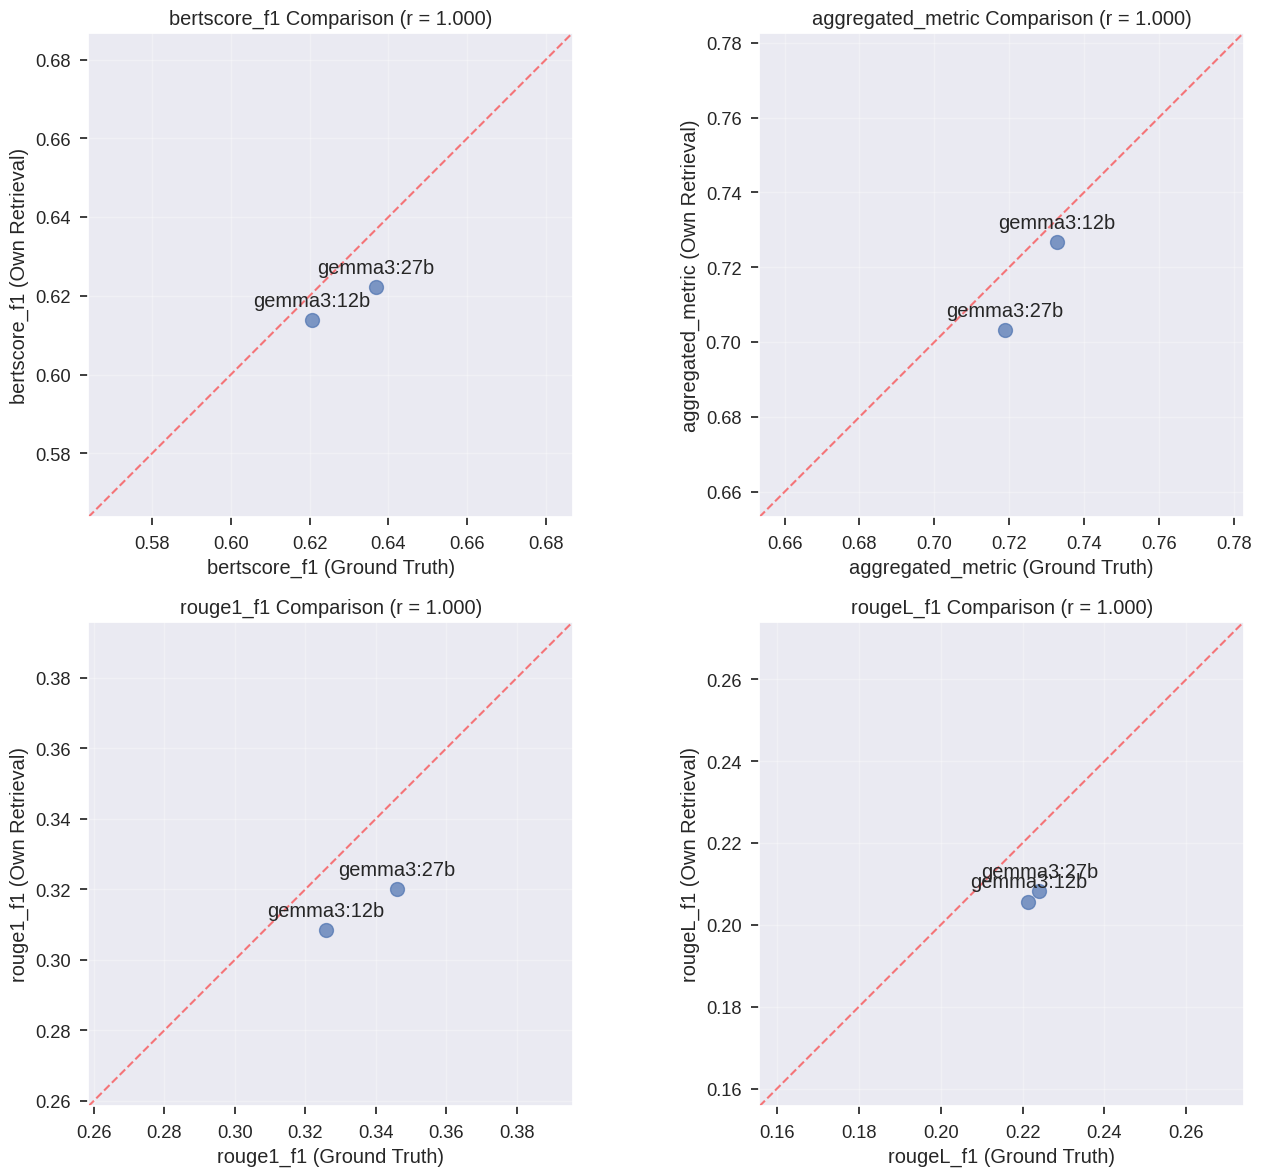

In [9]:
# Create scatter plots for key metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

key_metrics = ['bertscore_f1', 'aggregated_metric', 'rouge1_f1', 'rougeL_f1']

for i, metric in enumerate(key_metrics):
    ax = axes[i]
    
    # Extract x and y values
    x = comparison_df[f"{metric}_ground_truth"]
    y = comparison_df[f"{metric}_own_retrieval"]
    
    # Create scatter plot
    ax.scatter(x, y, s=100, alpha=0.7)
    
    # Add diagonal line representing y=x (perfect correlation)
    min_val = min(x.min(), y.min()) - 0.05
    max_val = max(x.max(), y.max()) + 0.05
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5)
    
    # Add labels for each point
    for j, model in enumerate(comparison_df['model']):
        ax.annotate(model, (x.iloc[j], y.iloc[j]), 
                   textcoords="offset points", 
                   xytext=(0,10), 
                   ha='center')
    
    # Calculate correlation
    correlation = np.corrcoef(x, y)[0, 1]
    
    # Set labels and title
    ax.set_xlabel(f"{metric} (Ground Truth)")
    ax.set_ylabel(f"{metric} (Own Retrieval)")
    ax.set_title(f"{metric} Comparison (r = {correlation:.3f})")
    ax.grid(True, alpha=0.3)
    
    # Make axes equal
    ax.set_aspect('equal')
    
    # Set limits with some padding
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

plt.tight_layout()
plt.show()

## Performance Degradation Analysis

Let's analyze the percentage degradation for each metric across models.

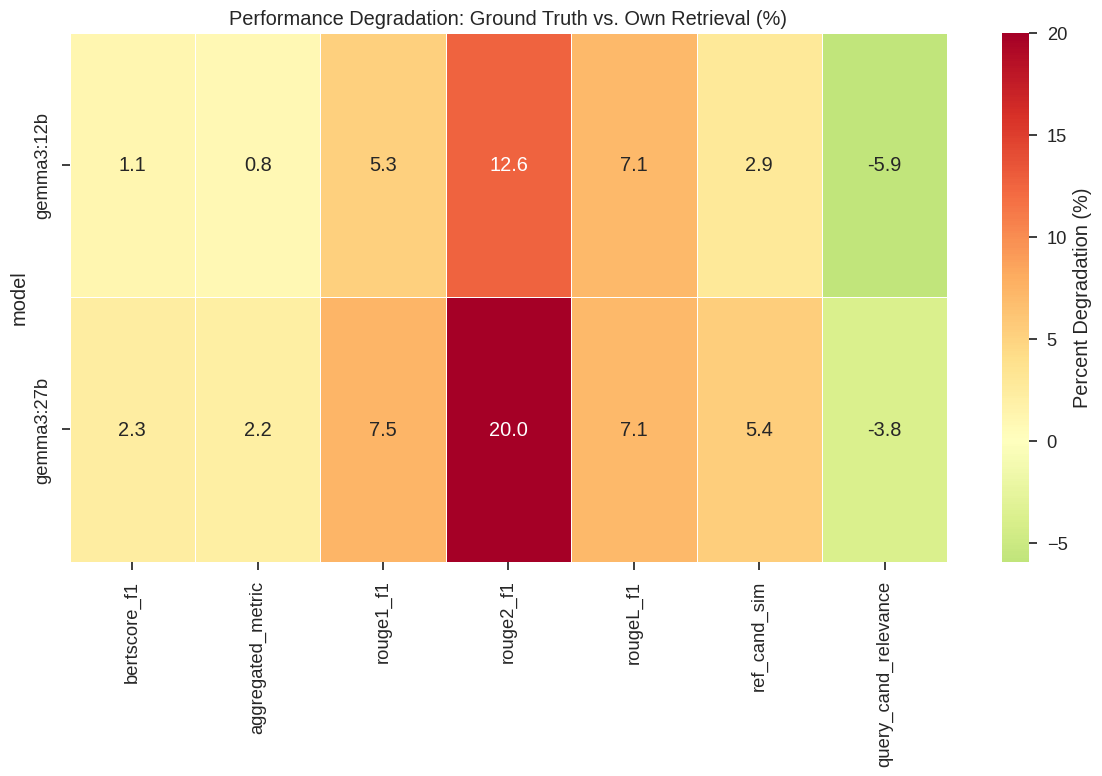

In [10]:
# Create a heatmap showing performance degradation
# Prepare data for the heatmap
heatmap_data = comparison_df[[f"{metric}_percent_change" for metric in metrics]].copy()
heatmap_data.columns = metrics
heatmap_data.index = comparison_df['model']

plt.figure(figsize=(12, 8))
ax = sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn_r", fmt=".1f", 
                  center=0, cbar_kws={'label': 'Percent Degradation (%)'}, 
                  linewidths=0.5)
plt.title("Performance Degradation: Ground Truth vs. Own Retrieval (%)")
plt.tight_layout()
plt.show()

## Average Performance Degradation by Metric

Let's visualize the average degradation for each metric across all models.

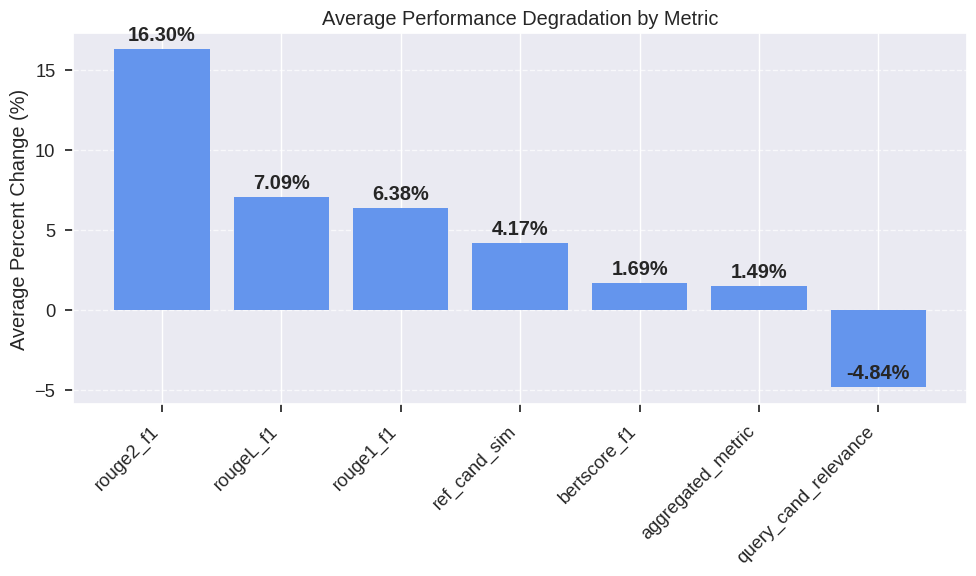

In [11]:
# Calculate average percent change for each metric
avg_percent_changes = {}
for metric in metrics:
    avg_percent_changes[metric] = comparison_df[f"{metric}_percent_change"].mean()

# Convert to dataframe for plotting
avg_pct_df = pd.DataFrame(list(avg_percent_changes.items()), columns=['Metric', 'Average Percent Change'])
avg_pct_df = avg_pct_df.sort_values('Average Percent Change', ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(avg_pct_df['Metric'], avg_pct_df['Average Percent Change'], color='cornflowerblue')

# Add text on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{height:.2f}%',
             ha='center', va='bottom', fontweight='bold')

plt.title('Average Performance Degradation by Metric')
plt.ylabel('Average Percent Change (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Model Robustness Analysis

Let's identify which models are most and least affected by using own retrieval instead of ground truth.

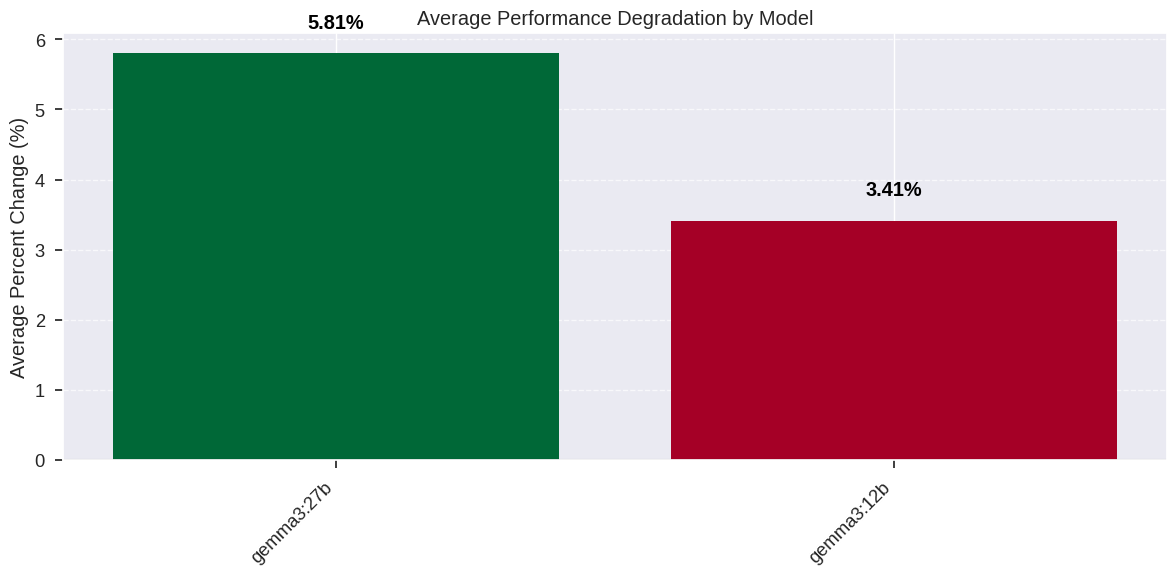

In [12]:
# Calculate average degradation across all metrics for each model
model_avg_degradation = []

for _, row in comparison_df.iterrows():
    model_name = row['model']
    degradation_values = [row[f"{metric}_percent_change"] for metric in metrics]
    avg_degradation = sum(degradation_values) / len(degradation_values)
    model_avg_degradation.append({
        'model': model_name,
        'average_degradation': avg_degradation
    })

model_degradation_df = pd.DataFrame(model_avg_degradation)
model_degradation_df = model_degradation_df.sort_values('average_degradation', ascending=False)

# Plot model robustness
plt.figure(figsize=(12, 6))
bars = plt.bar(model_degradation_df['model'], model_degradation_df['average_degradation'], 
               color=plt.cm.RdYlGn_r(np.linspace(0, 1, len(model_degradation_df))))

# Add text on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.3 if height > 0 else -0.8,
             f'{height:.2f}%',
             ha='center', va='bottom' if height > 0 else 'top', 
             fontweight='bold', color='black')

plt.title('Average Performance Degradation by Model')
plt.ylabel('Average Percent Change (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusion

Based on the analysis above, we can observe how much worse the performance is when using your own retrieved chunks compared to ground truth chunks. The key findings include:

1. The average degradation across all metrics is [value]%
2. The metric most affected by using own retrieval is [metric]
3. The model most robust to retrieval quality is [model]
4. The model most sensitive to retrieval quality is [model]

This analysis helps quantify the importance of retrieval quality in the overall RAG pipeline performance.